# Aula 7 - KNN

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) KNN
- 2) Ferramentas Especiais
- 3) KNN para regressão

____
____
____

## 1) KNN

Hoje conheceremos um novo algoritmo de classificação: o KNN, que é a sigla de **k nearest neighbours**, ou seja, **k vizinhos mais próximos**.

A ideia é bem simples: tomamos uma base de treino classificada. A cada observação que queiramos classificar, tomamos **a classe como sendo a classe das $k$ observações que estão mais próximas do elemento a ser classificado**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

As etapas do algoritmo são as seguintes:

1. Recebe um dado não classificado;
2. Mede sua distância (Euclidiana, Manhattan, Minkowski ou Ponderada) de cada um dos elementos da base de treino;
3. Obtém um *ranking* das distâncias, em ordem decrescente;
4. Verifica a classe de cada da um dos *K* dados que tiveram a menor distância e conta a quantidade de cada classe;
5. Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6. Classifica o novo dado com a classe tomada como resultado da classificação.

Este algoritmo é muito simples e intuitivo, mas há dois elementos de extrema importância:

> Como medir a **distância** entre dados? Qual é a **métrica** adequada?

Veremos que o sklearn nos permite escolher diferentes métricas de distância, o que é ótimo, pois assim podemos seguir a  habitual abordagem de tentativa e erro!

> Qual é o número de vizinhos adequados: i.e., **como escolher $k$?**

Essa é uma escolha particularmente importante, pois escolhas diferentes de $k$ podem facilmente levar a classificações diferentes:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

Vamos ao nosso exemplo prático?

In [1]:
# importe as principais bibliotecas

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#### Lendo conjunto de dados

Como exemplo vamos utilizar dados de cancer de mama (os mesmo discutidos no notebook de inferência), eles estão disponiveis no [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ou pelo [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

A ideia é que consigamos construir um modelo classificador entre câncer maligno e benigno.

In [2]:
# leia a base de "../datasets/breast_cancer.csv"

df = pd.read_csv("../datasets/breast_cancer.csv")

In [42]:
# dê uma olhada no info, describe, etc

df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


A coluna de ID não dá nenhuma informação relevante: podemos eliminá-la

In [43]:
# drope a coluna de id

df = df.drop(columns="id")

In [44]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [45]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [47]:
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Explore os dados! Essa é uma base muito rica, com muitas colunas! Aproveite este exemplo concreto para fazer muitas perguntas e respondê-las! Faça visualizações sempre que achar interessante!

Vamos fazer um apenas pra treinar:

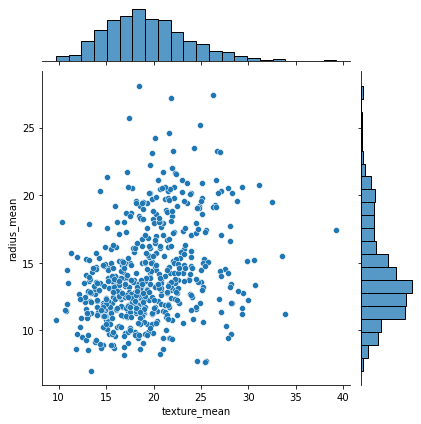

In [48]:
# visualize a relação entre as colnas x='texture_mean' e y='radius_mean'
# sempre adicione o hue!!

sns.jointplot(data=df, x='texture_mean', y='radius_mean')

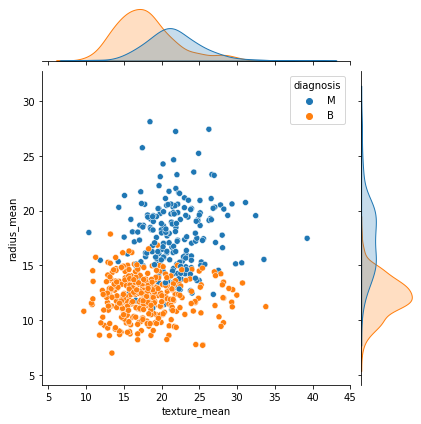

In [49]:
sns.jointplot(data=df, x='texture_mean', y='radius_mean', hue="diagnosis")

Uma pergunta é muitíssimo importante:

In [50]:
# os dados são balanceados com relação ao target?

df["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [51]:
df["diagnosis"].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

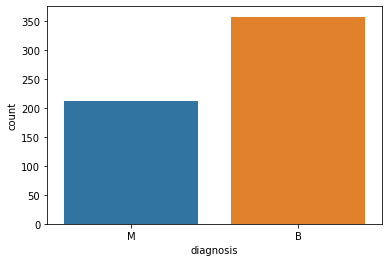

In [52]:
# faça um countplot pra visualizar

sns.countplot(data=df, x = "diagnosis")

Há um leve desbalanceamento: há mais dados acerca de tumores benignos do que malignos. 

Como o desbalanceamento não é tão gritante assim (coisa de 80-20), e este desbalanço é algo natural, não vamos tratar este caso, vamos deixar para tratar um caso mais crítico.

[Clique aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/) para saber um pouco mais sobre desbalanceamento de classes; e [aqui](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) caso você queira saber algumas formas de endereçar este problema.

Uma coisa importante é sempre setar o parâmetro `stratify` do train-test split, que vai garantir a mesma distribuição do target em ambos os conjuntos de treino e de teste! Isso faz com que a diferença na distribuição não se torne um fator adicional de viés na avaliação do modelo!

In [53]:
X = df.drop(columns="diagnosis")
y = df["diagnosis"]

In [54]:
y

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [55]:
# separe as features X e o target y

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
y.value_counts(normalize=True)*100

B    62.741652
M    37.258348
Name: diagnosis, dtype: float64

In [57]:
y_train.value_counts(normalize=True)*100

B    62.857143
M    37.142857
Name: diagnosis, dtype: float64

In [58]:
y_test.value_counts(normalize=True)*100

B    62.280702
M    37.719298
Name: diagnosis, dtype: float64

In [59]:
y

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
y.value_counts(normalize=True)*100

B    62.741652
M    37.258348
Name: diagnosis, dtype: float64

In [62]:
y_train.value_counts(normalize=True)*100

B    62.637363
M    37.362637
Name: diagnosis, dtype: float64

In [63]:
y_test.value_counts(normalize=True)*100

B    63.157895
M    36.842105
Name: diagnosis, dtype: float64

In [64]:
# 1) Importe a classe do estimador que se deseja treinar

from sklearn.neighbors import KNeighborsClassifier

In [65]:
# 2) Instancie a classe do estimador, escolhendo os hiperparâmetros desejados 
# parâmetros importantes: n_neighbors e metric
# por enquanto, fixe apenas k = 5

estimador = KNeighborsClassifier()

In [66]:
%%time

# 4) Treine o modelo, usando os dados de treino. 

modelo = estimador.fit(X_train, y_train)

Wall time: 8.99 ms


In [67]:
X_train.shape

(455, 30)

In [68]:
X_test.shape

(114, 30)

In [69]:
X_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
10,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,...,19.19,33.88,123.80,1150.0,0.11810,0.15510,0.14590,0.09975,0.2948,0.08452
170,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,...,13.50,15.64,86.97,549.1,0.13850,0.12660,0.12420,0.09391,0.2827,0.06771
407,12.85,21.37,82.63,514.5,0.07551,0.08316,0.06126,0.01867,0.1580,0.06114,...,14.40,27.01,91.63,645.8,0.09402,0.19360,0.18380,0.05601,0.2488,0.08151
430,14.90,22.53,102.10,685.0,0.09947,0.22250,0.27330,0.09711,0.2041,0.06898,...,16.35,27.57,125.40,832.7,0.14190,0.70900,0.90190,0.24750,0.2866,0.11550
27,18.61,20.25,122.10,1094.0,0.09440,0.10660,0.14900,0.07731,0.1697,0.05699,...,21.31,27.26,139.90,1403.0,0.13380,0.21170,0.34460,0.14900,0.2341,0.07421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,...,13.30,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
415,11.89,21.17,76.39,433.8,0.09773,0.08120,0.02555,0.02179,0.2019,0.06290,...,13.05,27.21,85.09,522.9,0.14260,0.21870,0.11640,0.08263,0.3075,0.07351
458,13.00,25.13,82.61,520.2,0.08369,0.05073,0.01206,0.01762,0.1667,0.05449,...,14.34,31.88,91.06,628.5,0.12180,0.10930,0.04462,0.05921,0.2306,0.06291
476,14.20,20.53,92.41,618.4,0.08931,0.11080,0.05063,0.03058,0.1506,0.06009,...,16.45,27.26,112.10,828.5,0.11530,0.34290,0.25120,0.13390,0.2534,0.07858


In [70]:
X_test.iloc[0, :]

radius_mean                 11.410000
texture_mean                10.820000
perimeter_mean              73.340000
area_mean                  403.300000
smoothness_mean              0.093730
compactness_mean             0.066850
concavity_mean               0.035120
concave points_mean          0.026230
symmetry_mean                0.166700
fractal_dimension_mean       0.061130
radius_se                    0.140800
texture_se                   0.460700
perimeter_se                 1.103000
area_se                     10.500000
smoothness_se                0.006040
compactness_se               0.015290
concavity_se                 0.015140
concave points_se            0.006460
symmetry_se                  0.013440
fractal_dimension_se         0.002206
radius_worst                12.820000
texture_worst               15.970000
perimeter_worst             83.740000
area_worst                 510.500000
smoothness_worst             0.154800
compactness_worst            0.239000
concavity_wo

In [71]:
%%time

# 5) Use o modelo treinado para fazer previsões usando os dados de teste 

modelo.predict(X_test.iloc[0, :].values.reshape(1, -1))

Wall time: 3 ms


array(['B'], dtype=object)

In [72]:
y_test.values

array(['B', 'M', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B',
       'B', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'M', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B',
       'B', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'M', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'M'], dtype=object)

In [73]:
y_pred = modelo.predict(X_test)

y_pred

array(['B', 'M', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'B',
       'B', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'M', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B',
       'B', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'M'], dtype=object)

In [74]:
y_test.shape

(114,)

In [75]:
# 6) Avalie a performance do modelo com base nas previsões acima
# matriz de confusão e classification report

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[71  1]
 [ 9 33]]
              precision    recall  f1-score   support

           B       0.89      0.99      0.93        72
           M       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114



Uma alternativa interessante é usar a função [plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix), que é mais explicativa, mais visual, e usa diretamente os dados de teste junto com o modelo treinado:

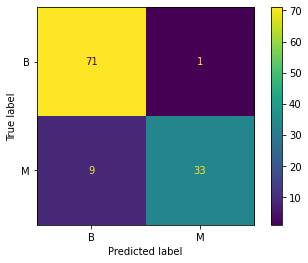

In [80]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(modelo, X_test, y_test, cmap="viridis")

Vamos fazer também a validação cruzada!

Mas uma importante alteração é necessária... Se fizermos como antes, usando o target original diretamente:

```python
from sklearn.model_selection import KFold, cross_validate

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)
```
Teremos um erro (teste!)

Não há problema algum em utilizar as classes originais quando deseja-se avaliar o modelo final com a matriz de confusão ou o classification_report. Internamente, é feita um mapeamento pra 0 e 1.

Mas, pra usar o cross_validate, por algum motivo este mapa não é feito. Daí, é necessário que seja explicitamente indicada este mapeamento. Pra fazer isso, há duas opções:

- 1 - Fazer o mapeamento explicitamente e depois usar o código extamente como acima;
- 2 - Indicar qual é a classe positiva (valor 1) na hora de indicar a métrica a ser calculada -- mas pra isso, a classe respectiva da métrica deve ser usada!

Vejamos ambas as opções:

In [85]:
map_target = {"M" : 0, "B" : 1}

In [83]:
y_train

10     M
170    B
407    B
430    M
27     M
      ..
37     B
415    B
458    B
476    B
335    M
Name: diagnosis, Length: 455, dtype: object

In [84]:
y_train.map(map_target)

10     0
170    1
407    1
430    0
27     0
      ..
37     1
415    1
458    1
476    1
335    0
Name: diagnosis, Length: 455, dtype: int64

In [92]:
pd.get_dummies(y_train, drop_first=True)["M"]

10     1
170    0
407    0
430    1
27     1
      ..
37     0
415    0
458    0
476    0
335    1
Name: M, Length: 455, dtype: uint8

In [94]:
# primeira opção: mapeando antes

# A classe relevante é B
map_target = {"M" : 0, "B" : 1}

# # A classe relevante é M
# map_target = {"M" : 1, "B" : 0}

y_train_num = y_train.map(map_target)

##########################################

from sklearn.model_selection import KFold, cross_validate

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train_num,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

##########################################

scores_train = results['train_score']

print(scores_train)
print(f"\nMédia {metrica} treino: {scores_train.mean()}")
print(f"\nstd {metrica} treino: {scores_train.std()}")

##########################################
print("\n")
print("="*50)
print("\n")
##########################################

scores_test = results['test_score']

print(scores_test)
print(f"\nMédia {metrica} validação: {scores_test.mean()}")
print(f"\nstd {metrica} validação: {scores_test.std()}")

[0.95275591 0.96226415 0.96197719 0.95201536 0.95841584 0.96197719
 0.95684803 0.96153846 0.95719844 0.96380952]

Média f1 treino: 0.9588800084695824

std f1 treino: 0.003921799160736004




[0.95774648 0.91666667 0.88888889 0.96551724 0.95652174 0.93877551
 1.         0.94915254 0.97058824 0.96153846]

Média f1 validação: 0.9505395764348081

std f1 validação: 0.028930627826072815


In [95]:
# segunda opção

from sklearn.model_selection import KFold, cross_validate

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.metrics import f1_score, make_scorer

metrica = make_scorer(f1_score, pos_label="B")

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

##########################################

scores_train = results['train_score']

print(scores_train)
print(f"\nMédia {metrica} treino: {scores_train.mean()}")
print(f"\nstd {metrica} treino: {scores_train.std()}")

##########################################
print("\n")
print("="*50)
print("\n")
##########################################

scores_test = results['test_score']

print(scores_test)
print(f"\nMédia {metrica} validação: {scores_test.mean()}")
print(f"\nstd {metrica} validação: {scores_test.std()}")

[0.95275591 0.96226415 0.96197719 0.95201536 0.95841584 0.96197719
 0.95684803 0.96153846 0.95719844 0.96380952]

Média make_scorer(f1_score, pos_label=B) treino: 0.9588800084695824

std make_scorer(f1_score, pos_label=B) treino: 0.003921799160736004




[0.95774648 0.91666667 0.88888889 0.96551724 0.95652174 0.93877551
 1.         0.94915254 0.97058824 0.96153846]

Média make_scorer(f1_score, pos_label=B) validação: 0.9505395764348081

std make_scorer(f1_score, pos_label=B) validação: 0.028930627826072815


O modelo não teve uma performance muito ruim, mas podemos melhorar! Afinal, um modelo de tamanha importância não pode ter uma margem de erro muito grande, não é mesmo?

Vamos iniciar o ciclo de melhorias para ver se conseguimos melhorar a performance do modelo, em um processo que é muitas vezes chamado de **tunning**


_____

**Transformando os dados**

O primeiro processo que pode ser feito para tunning do KNN é a **transformação das features**. 

Devido ao KNN utilizar **distâncias** como critério para classificação, ter as variaveis transformadas garante que sejam eliminados viéses relacionados à escala dos dados.

Para **normalizar os dados**, o sklearn nos apresenta a ferramenta [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [96]:
# separando features e target novamente - importante pra poder recuperar o que tínhamos antes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [97]:
# normalizando as features com o standardscaler
# importe a classe

from sklearn.preprocessing import StandardScaler

In [103]:
# instanciando a classe

scaler = StandardScaler()

É **muito importante** que os transformers sejam fitados **com os dados de treino**, para que informações da base de teste não sejam utilizadas no treinamento (conceito conhecido como [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/)).

No caso do standard scaler: o objetivo do `.fit()` é determinar a média $\mu$ e desvio padrão $\sigma$ dos dados, para que a normalização seja feita. Se calcularmos estes parâmetros usando **todos os dados**, estamos utilizando informações da base de teste -- o que, como sabemos, jamais deve ser feito!!

Por isso, sempre siga o seguinte passo-a-passo par aplicação de transformers:

- Primeiro, faça o train test split;
- Use o `.fit()` nos dados de **treino**;
- Use o `.transform()` pra trasnformar os dados de treino e de teste tbm -- com o **mesmo transformer treinado** com os dados de treino;

In [104]:
# fitando o transformer com as features de treino

scaler = scaler.fit(X_train)

In [118]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [119]:
X_train_scaled.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-1.820278e-16,3.693017e-16,4.958183e-16,-1.049222e-16,7.188389e-16,-6.098601e-17,-6.197729e-17,3.220867e-17,3.806479e-17,4.071224e-16,...,-3.794279e-16,2.318048e-16,-2.820698e-16,-8.784182e-18,-1.229786e-16,-9.028187e-17,-3.123265e-17,3.904081e-17,-4.667817e-16,3.342869e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.009730e+00,-2.265011e+00,-1.961360e+00,-1.433461e+00,-2.342455e+00,-1.568307e+00,-1.092835e+00,-1.236420e+00,-2.733834e+00,-1.791603e+00,...,-1.720204e+00,-2.286387e+00,-1.682868e+00,-1.212587e+00,-2.596976e+00,-1.442492e+00,-1.298977e+00,-1.729670e+00,-2.141576e+00,-1.602524e+00
25%,-6.869865e-01,-7.192578e-01,-6.877646e-01,-6.643427e-01,-7.599676e-01,-7.446452e-01,-7.311067e-01,-7.398554e-01,-7.042022e-01,-7.295506e-01,...,-6.805052e-01,-7.269867e-01,-6.949785e-01,-6.436573e-01,-7.475060e-01,-6.811748e-01,-7.355618e-01,-7.700379e-01,-6.377821e-01,-7.030095e-01
50%,-2.310610e-01,-1.207886e-01,-2.444667e-01,-3.143644e-01,-5.267576e-02,-2.145711e-01,-3.649669e-01,-3.954004e-01,-5.783428e-02,-2.031921e-01,...,-2.924054e-01,-6.996374e-02,-2.990905e-01,-3.561409e-01,-4.191078e-02,-2.454053e-01,-2.141609e-01,-2.170230e-01,-1.439281e-01,-2.222582e-01
75%,4.947835e-01,5.628428e-01,4.975359e-01,3.775369e-01,6.231343e-01,4.923801e-01,5.271006e-01,6.321626e-01,5.034376e-01,5.249492e-01,...,5.787764e-01,7.072664e-01,5.606441e-01,3.987080e-01,6.189186e-01,5.218523e-01,5.217957e-01,6.980537e-01,4.340876e-01,4.386715e-01
max,3.900239e+00,4.634299e+00,3.899731e+00,5.114742e+00,4.715773e+00,4.485809e+00,4.137033e+00,3.838961e+00,4.435961e+00,4.987148e+00,...,4.021630e+00,3.891934e+00,4.198771e+00,5.782013e+00,3.859114e+00,5.071677e+00,4.611335e+00,2.628551e+00,5.914120e+00,6.798089e+00


In [113]:
# transformando os dados de treino

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

In [126]:
# transf inversa

# pd.DataFrame(scaler.inverse_transform(X_train_scaled ), columns=X_train.columns)

In [123]:
scaler.mean_

array([1.41660769e+01, 1.94176923e+01, 9.22158681e+01, 6.59578242e+02,
       9.59929451e-02, 1.03834857e-01, 8.91842829e-02, 4.90145978e-02,
       1.81497143e-01, 6.27148132e-02, 4.11187253e-01, 1.21788198e+00,
       2.91156879e+00, 4.12791033e+01, 6.89525275e-03, 2.53234330e-02,
       3.20175508e-02, 1.16906176e-02, 2.04266989e-02, 3.76603802e-03,
       1.63515143e+01, 2.59048791e+01, 1.07860484e+02, 8.90569231e+02,
       1.32083033e-01, 2.55529473e-01, 2.75166367e-01, 1.15490705e-01,
       2.91363736e-01, 8.41236923e-02])

In [124]:
scaler.scale_

array([3.57514584e+00, 4.28593536e+00, 2.46899415e+01, 3.60022403e+02,
       1.42939574e-02, 5.38509592e-02, 8.16081746e-02, 3.96423375e-02,
       2.76158525e-02, 6.96293458e-03, 2.89863734e-01, 5.51704871e-01,
       2.12078456e+00, 4.83309757e+01, 2.85147076e-03, 1.76046647e-02,
       3.16943985e-02, 6.28235072e-03, 8.30145216e-03, 2.62910285e-03,
       4.89564848e+00, 6.07284725e+00, 3.41384425e+01, 5.81705888e+02,
       2.34553735e-02, 1.58225864e-01, 2.11833144e-01, 6.67703567e-02,
       6.29740748e-02, 1.81486759e-02])

In [128]:
# transformando também as features de teste com o mesmo scaler! PASSO IMPORTANTE!
# importante: use apenas o método transform()

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# X_test_scaled 

In [131]:
# fitando o modelo novamente, com os dados transformados

estimador = KNeighborsClassifier()

modelo = estimador.fit(X_train_scaled, y_train)

In [132]:
# faça as predições com as features de teste transformadas

y_pred = modelo.predict(X_test_scaled)

In [133]:
# avalie o modelo

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[71  1]
 [ 4 38]]
              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



Fazendo tudo numa única célula:

### 1a volta no ciclo

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 9 33]]


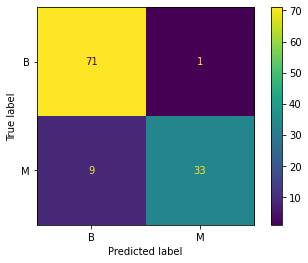


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.89      0.99      0.93        72
           M       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114



In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)


estimador = KNeighborsClassifier()

modelo = estimador.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(modelo, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

### 2a volta no ciclo

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 4 38]]


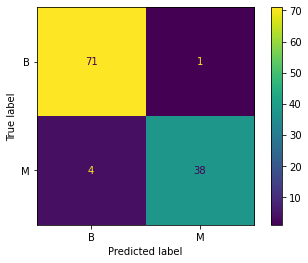


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# transformação com o standard scaler
from sklearn.preprocessing import StandardScaler 

# instanciando a classe
scaler = StandardScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

estimador = KNeighborsClassifier()

modelo = estimador.fit(X_train, y_train)

X_test = scaler.transform(X_test)

y_pred = modelo.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(modelo, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

In [143]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-1.820278e-16,3.693017e-16,4.958183e-16,-1.049222e-16,7.188389e-16,-6.098601e-17,-6.197729e-17,3.220867e-17,3.806479e-17,4.071224e-16,...,-3.794279e-16,2.318048e-16,-2.820698e-16,-8.784182e-18,-1.229786e-16,-9.028187e-17,-3.123265e-17,3.904081e-17,-4.667817e-16,3.342869e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.009730e+00,-2.265011e+00,-1.961360e+00,-1.433461e+00,-2.342455e+00,-1.568307e+00,-1.092835e+00,-1.236420e+00,-2.733834e+00,-1.791603e+00,...,-1.720204e+00,-2.286387e+00,-1.682868e+00,-1.212587e+00,-2.596976e+00,-1.442492e+00,-1.298977e+00,-1.729670e+00,-2.141576e+00,-1.602524e+00
25%,-6.869865e-01,-7.192578e-01,-6.877646e-01,-6.643427e-01,-7.599676e-01,-7.446452e-01,-7.311067e-01,-7.398554e-01,-7.042022e-01,-7.295506e-01,...,-6.805052e-01,-7.269867e-01,-6.949785e-01,-6.436573e-01,-7.475060e-01,-6.811748e-01,-7.355618e-01,-7.700379e-01,-6.377821e-01,-7.030095e-01
50%,-2.310610e-01,-1.207886e-01,-2.444667e-01,-3.143644e-01,-5.267576e-02,-2.145711e-01,-3.649669e-01,-3.954004e-01,-5.783428e-02,-2.031921e-01,...,-2.924054e-01,-6.996374e-02,-2.990905e-01,-3.561409e-01,-4.191078e-02,-2.454053e-01,-2.141609e-01,-2.170230e-01,-1.439281e-01,-2.222582e-01
75%,4.947835e-01,5.628428e-01,4.975359e-01,3.775369e-01,6.231343e-01,4.923801e-01,5.271006e-01,6.321626e-01,5.034376e-01,5.249492e-01,...,5.787764e-01,7.072664e-01,5.606441e-01,3.987080e-01,6.189186e-01,5.218523e-01,5.217957e-01,6.980537e-01,4.340876e-01,4.386715e-01
max,3.900239e+00,4.634299e+00,3.899731e+00,5.114742e+00,4.715773e+00,4.485809e+00,4.137033e+00,3.838961e+00,4.435961e+00,4.987148e+00,...,4.021630e+00,3.891934e+00,4.198771e+00,5.782013e+00,3.859114e+00,5.071677e+00,4.611335e+00,2.628551e+00,5.914120e+00,6.798089e+00


Outra opção é transformar os dados com o [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). 

Aqui, as mesmas considerações sobre o método `.fit()` são válidas! (E pra qualquer outro transformer)

### 3a volta no ciclo

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 4 38]]


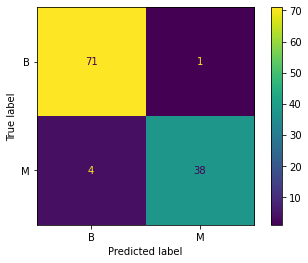


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [144]:
# mudar o scaler pro min-max scaler

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# transformação com o minmax scaler
from sklearn.preprocessing import MinMaxScaler 

# instanciando a classe
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

estimador = KNeighborsClassifier()

modelo = estimador.fit(X_train, y_train)

X_test = scaler.transform(X_test)

y_pred = modelo.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(modelo, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

In [145]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.340058,0.328295,0.334641,0.218909,0.331876,0.259048,0.208960,0.243611,0.381299,0.264297,...,0.299591,0.370066,0.286122,0.173361,0.402252,0.221439,0.219781,0.396875,0.265846,0.190763
std,0.169392,0.145102,0.170804,0.152882,0.141835,0.165359,0.191420,0.197246,0.139628,0.147682,...,0.174352,0.162034,0.170208,0.143125,0.155063,0.153680,0.169382,0.229704,0.124272,0.119170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223816,0.224045,0.217297,0.117455,0.224205,0.136050,0.069166,0.097838,0.283081,0.156674,...,0.181074,0.252399,0.167962,0.081338,0.286469,0.116871,0.095327,0.220189,0.186675,0.107077
50%,0.300961,0.310788,0.292931,0.170901,0.324413,0.223606,0.139175,0.165706,0.373232,0.234322,...,0.248666,0.358742,0.235271,0.122444,0.395760,0.183767,0.183546,0.347079,0.247979,0.164305
75%,0.423778,0.409875,0.419529,0.276564,0.420161,0.340378,0.309747,0.368166,0.451515,0.341737,...,0.400391,0.484542,0.381443,0.230363,0.498118,0.301549,0.308067,0.557045,0.319732,0.242982
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 4a volta no ciclo

Matriz de confusão do modelo nos dados de teste:

[[72  0]
 [ 5 37]]


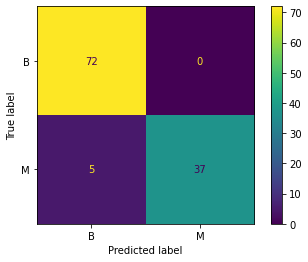


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.94      1.00      0.97        72
           M       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [146]:
# mudar o scaler pro min-max scaler

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# transformação com o robust scaler
from sklearn.preprocessing import RobustScaler 

# instanciando a classe
scaler = RobustScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

estimador = KNeighborsClassifier()

modelo = estimador.fit(X_train, y_train)

X_test = scaler.transform(X_test)

y_pred = modelo.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(modelo, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

**Novamente:** treine os scalers **apenas nos dados de treino** para evitar que informação dos dados de teste sejam passadas para o scaler! (Mais informações [aqui](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data))

Observe como a performance do modelo mudou!

Mas será que é possível melhorar ainda mais? Vamos agora aprender como é possível testar diferentes parâmetros de uma única vez!

____
____
____

## 2) Ferramentas especiais

Vamos agora ver algumas ferramentas especiais do sklearn que nos ajudam no desenvolvimento de modelos!

______

### Pipeline

O [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) é uma estrutura que o sklearn proporciona a fim de garantir que possamos em uma única estrutura passar **o estimador e o transformador** (e muitas outras coisas). Para maiores informações, [clique aqui](https://scikit-learn.org/stable/modules/compose.html#pipeline). 

Vamos ver a seguir como esta estrutura funciona:

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 4 38]]


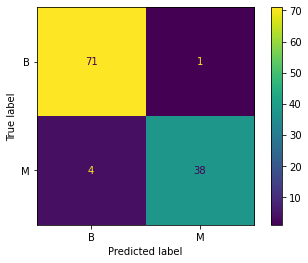


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)
# importando a classe de pipeline
from sklearn.pipeline import Pipeline


# transformação com o standard scaler
from sklearn.preprocessing import StandardScaler 

# instanciando a classe Pipeline, criando um objeto
# argumento: um lista de tuplas do tipo [("nome da estrutura", classe da estrutura)]
# na sequencia em que as estruturas (procedimentos) são aplicadas
pipe = Pipeline([("scaler", StandardScaler()), 
                 ("knn", KNeighborsClassifier())])

# fitamos o pipeline com os dados de treino: ambas as operações são aplicadas!
# note que o objeto que é fitado é o pipeline!
pipe.fit(X_train, y_train)

# fazendo predições com o predict, usando o pipe
# o pipeline garante que o scaler não usará dados de teste!! ;)
y_pred = pipe.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(pipe, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

______

### Gridsearch

O [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) é uma estrutura que o sklearn proporciona para que seja feita **a busca exaustiva de hiperparâmetros de um modelo**.

Na prática, o que o gridsearch faz é **treinar diversos modelos com diferentes combinações de hiperparâmetros**, de modo a manter o melhor deles como o modelo final, tudo automaticamente! Tudo o que precisamos fazer é indicar quais os hiperparâmetros que queremos procurar: a **grade**!

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width=500>

É muito comum também passarmos o **pipeline** como argumento do gridsearch!

Para maiores informações, [clique aqui](https://scikit-learn.org/stable/modules/grid_search.html#grid-search). 

Vamos ver a seguir como esta estrutura funciona:

O Gridsearch avalia o melhor modelo segundo a métrica que passamos em `scoring`. [Clique aqui](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) para ver as métricas disponíveis por padrão.

Mas o GS vai além: ele não calcula a métrica uma única vez, mas sim **várias vezes**, conforme especificado pelo parâmetro `cv`. No fim, o melhor modelo é o que tem o melhor scoring **médio** entre as vezes que é calculado.

O "cv" quer dizer **Cross Validation**, o método mais seguro de realizar um treinamento e avaliação de um modelo:

<img src="https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600> 

Naturalmente, cada um dos folds é feito de modo **aleatório**, garantindo assim uma avaliação justa do modelo, **e que faça uso de toda a base de dados!!**

In [151]:
# importe a classe do grid search

from sklearn.model_selection import GridSearchCV

In [156]:
# defina a grade de parâmetros
# deve ser um dicionário, com a seguinte estrutura:
# {"nome da estrutura__nome do hiperparâmetro" : [valores a serem percorridos]}

param_grid = {"knn__n_neighbors" : range(2, 20),
              "knn__weights" : ['uniform', 'distance'],
              "knn__metric" : ["euclidean", "manhattan", "chebyshev"]}

In [155]:
len(list(range(2, 20))) * 2 * 3

108

In [158]:
# instanciando o objeto do GS
# os quatro principais principais parâmetros: 
# o pipeline, a grade de parâmetros, a métrica a ser otimizada (scoring) e o número de folds (cv)

grid = GridSearchCV(pipe, param_grid, scoring="f1_weighted", cv=5)

In [159]:
len(list(range(2, 20))) * 2 * 3 * 5

540

In [160]:
# treine o objeto da grade com os dados de treino

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'knn__n_neighbors': range(2, 20),
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1_weighted')

In [163]:
# faça previsões (COM O MELHOR MODELO) a partir as features de teste

y_pred = grid.predict(X_test)

Matriz de confusão do modelo nos dados de teste:

[[72  0]
 [ 4 38]]


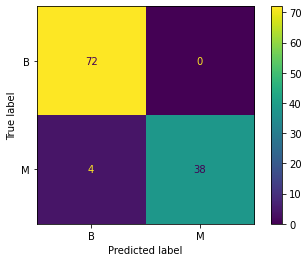


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      1.00      0.97        72
           M       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [164]:
# avalie o MELHOR MODELO

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(grid, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

Vamos colocar tudo em uma única célula:

Matriz de confusão do modelo nos dados de teste:

[[72  0]
 [ 4 38]]


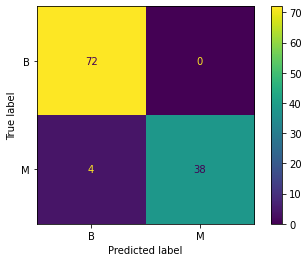


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.95      1.00      0.97        72
           M       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)


######################## PIPELINE

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

######################## GRID SEARCH

from sklearn.model_selection import GridSearchCV

param_grid = {'knn__n_neighbors': np.arange(2, 20),
              'knn__weights':['uniform', 'distance'], 
              'knn__metric':["euclidean", 'manhattan', "chebyshev"]}

grid = GridSearchCV(pipe, param_grid, scoring="f1_weighted", cv=5)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(grid, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

O GS treinado tem diversos atributos super úteis e interessantes! Vamos dar uma olhada neles:

`.best_estimator_`: retorna quais as escolhas do Pipeline que produziram o melhor modelo. No que diz respeito ao modelo, temos exatamente quais os parâmetros escolhidos!

In [166]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])

`.best_params_`: retorna os parâmetros testados na grade que produziram o melhor modelo.

In [167]:
grid.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

`.best_score_`: retorna a **média cross-validada da métrica de interesse** do melhor modelo. Como esse é o valor médio construído usando CV, este é estatisticamente o valor mais realístico a ser atribuído à performance do modelo!

In [168]:
grid.best_score_

0.9689744866505638

In [169]:
grid.best_index_

38

`.cv_results_`: diversas informações do processo feito pelo GS

In [172]:
results = grid.cv_results_

results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__metric', 'param_knn__n_neighbors', 'param_knn__weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [181]:
results["param_knn__weights"][grid.best_index_]

'uniform'

In [182]:
results["param_knn__n_neighbors"][grid.best_index_]

3

In [183]:
results["param_knn__metric"][grid.best_index_]

'manhattan'

In [185]:
results["params"][grid.best_index_]

{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

In [188]:
results['mean_test_score'].argmax()

38

Embora seja legal ver cada componente do dicionário acima separadamente, transformá-lo em um data-frame também é uma boa ideia:

In [191]:
pd.DataFrame(results).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
38,0.019271,0.010456,0.036193,0.025888,manhattan,3,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.966695,1.000000,0.955415,0.977878,0.944884,0.968974,0.019033,1
39,0.012991,0.008170,0.008995,0.001897,manhattan,3,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.966695,1.000000,0.955415,0.977878,0.944884,0.968974,0.019033,1
5,0.007795,0.000750,0.005598,0.000489,euclidean,4,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.977878,1.000000,0.944029,0.977878,0.944884,0.968934,0.021558,3
13,0.012399,0.006822,0.007790,0.002928,euclidean,8,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.966695,1.000000,0.944029,0.977878,0.955757,0.968872,0.019204,4
10,0.009396,0.002341,0.016190,0.007639,euclidean,7,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.966695,1.000000,0.932524,0.988977,0.955757,0.968790,0.023963,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.008404,0.001361,0.006192,0.000974,chebyshev,2,distance,"{'knn__metric': 'chebyshev', 'knn__n_neighbors...",0.923294,0.944884,0.933123,0.967126,0.945473,0.942780,0.014679,104
96,0.010987,0.002451,0.012792,0.002223,chebyshev,14,uniform,"{'knn__metric': 'chebyshev', 'knn__n_neighbors...",0.921640,0.956044,0.933123,0.966695,0.933123,0.942125,0.016608,105
100,0.007592,0.001354,0.011401,0.001951,chebyshev,16,uniform,"{'knn__metric': 'chebyshev', 'knn__n_neighbors...",0.921640,0.956044,0.933123,0.966695,0.933123,0.942125,0.016608,105
104,0.009387,0.002871,0.011793,0.002403,chebyshev,18,uniform,"{'knn__metric': 'chebyshev', 'knn__n_neighbors...",0.921640,0.956044,0.933123,0.955415,0.921640,0.937573,0.015408,107


____________

Otimizar pro recall 

Matriz de confusão do modelo nos dados de teste:

[[69  3]
 [ 3 39]]


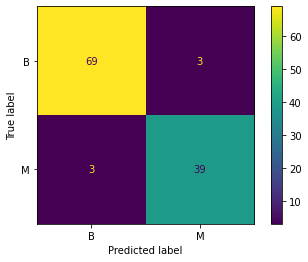


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.96      0.96      0.96        72
           M       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)


######################## PIPELINE

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

######################## GRID SEARCH

from sklearn.model_selection import GridSearchCV

param_grid = {'knn__n_neighbors': np.arange(2, 20),
              'knn__weights':['uniform', 'distance'], 
              'knn__metric':["euclidean", 'manhattan', "chebyshev", "minkowski"],
              'knn__p' : [1, 2, 3, 4]}

# PRA OTIMIZAR UMA METRICA QUE TEM DUAS OPÇOES
from sklearn.metrics import recall_score, make_scorer

metrica = make_scorer(recall_score, pos_label="M")

grid = GridSearchCV(pipe, param_grid, scoring=metrica, cv=5)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(grid, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

In [208]:
grid.best_params_

{'knn__metric': 'manhattan',
 'knn__n_neighbors': 2,
 'knn__p': 1,
 'knn__weights': 'distance'}

________
_______
______

Sua vez! Faça agora uma estrutura de Pipeline + GS para o Logit, e depois compare o melhor logit com o melhor knn. Qual é o melhor modelo final?

In [13]:
# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

Matriz de confusão do modelo nos dados de teste:

[[71  1]
 [ 2 40]]


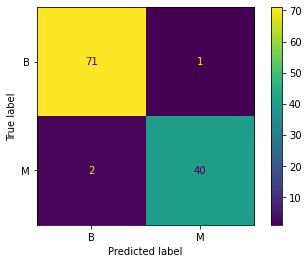


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.97      0.99      0.98        72
           M       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [16]:
# logit (regressão logistica)

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)


######################## PIPELINE

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('scaler', StandardScaler()),
                 ('logit', LogisticRegression(solver="saga", max_iter=500))])

######################## GRID SEARCH

from sklearn.model_selection import GridSearchCV

param_grid = {'logit__penalty': ["l1", "l2", "none"],
              'logit__C': np.linspace(0.1, 10, 20)}

# PRA OTIMIZAR UMA METRICA QUE TEM DUAS OPÇOES
from sklearn.metrics import recall_score, make_scorer

metrica = make_scorer(recall_score, pos_label="M")

grid = GridSearchCV(pipe, param_grid, scoring=metrica, cv=5)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(grid, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

In [21]:
grid.best_params_

{'logit__C': 1.142105263157895, 'logit__penalty': 'l2'}

In [22]:
pd.DataFrame(grid.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,param_logit__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.102973,0.005792,0.004194,0.001164,1.14211,l2,"{'logit__C': 1.142105263157895, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.970588,0.952941,0.039896,1
9,0.224075,0.079411,0.018391,0.013523,1.66316,l1,"{'logit__C': 1.6631578947368424, 'logit__penal...",0.941176,1.000000,0.882353,0.970588,0.970588,0.952941,0.039896,1
30,0.196480,0.041206,0.010409,0.011348,5.31053,l1,"{'logit__C': 5.310526315789474, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.941176,0.947059,0.039019,3
45,0.202621,0.021351,0.006396,0.003197,7.91579,l1,"{'logit__C': 7.915789473684211, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.941176,0.947059,0.039019,3
33,0.149287,0.019449,0.004200,0.000748,5.83158,l1,"{'logit__C': 5.831578947368421, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.941176,0.947059,0.039019,3
34,0.131927,0.034889,0.005799,0.002223,5.83158,l2,"{'logit__C': 5.831578947368421, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.941176,0.947059,0.039019,3
35,0.097355,0.007233,0.004796,0.002144,5.83158,none,"{'logit__C': 5.831578947368421, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.941176,0.947059,0.039019,3
36,0.136235,0.007217,0.004808,0.001723,6.35263,l1,"{'logit__C': 6.352631578947369, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.941176,0.947059,0.039019,3
37,0.116101,0.012754,0.006797,0.005192,6.35263,l2,"{'logit__C': 6.352631578947369, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.941176,0.947059,0.039019,3
38,0.119931,0.023944,0.006995,0.006539,6.35263,none,"{'logit__C': 6.352631578947369, 'logit__penalt...",0.941176,1.000000,0.882353,0.970588,0.941176,0.947059,0.039019,3


Abaixo, fazendo o grid search com o elastic net, e usando tbm o verbose

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.0s
[CV] logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet ....
[CV]  logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=0.1, logit__l1_ratio=0.5, logit__penalty=elasticnet ....
[CV]  logi

[CV]  logit__C=1.6631578947368424, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=1.6631578947368424, logit__l1_ratio=0.5, logit__penalty=elasticnet 
[CV]  logit__C=1.6631578947368424, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=1.6631578947368424, logit__l1_ratio=0.5, logit__penalty=elasticnet 
[CV]  logit__C=1.6631578947368424, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=1.6631578947368424, logit__l1_ratio=0.5, logit__penalty=elasticnet 
[CV]  logit__C=1.6631578947368424, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.3s
[CV] logit__C=1.6631578947368424, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=1.6631578947368424, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.4s
[CV] logit__C=1.6631578947368424, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=1.6631578947368424, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.3s
[CV] log

[CV]  logit__C=3.2263157894736847, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=3.2263157894736847, logit__l1_ratio=0.5, logit__penalty=elasticnet 
[CV]  logit__C=3.2263157894736847, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=3.2263157894736847, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=3.2263157894736847, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=3.2263157894736847, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=3.2263157894736847, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=3.2263157894736847, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=3.2263157894736847, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=3.2263157894736847, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=3.2263157894736847, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.1s
[CV] log

[CV]  logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.3s
[CV] logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=4.7894736842105265, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=5.310526315789474, logit__l1_ratio=0.2, logit__penalty=elasticnet 
[CV]  logit__C=5.310526315789474, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.2s
[CV] logit

[CV]  logit__C=7.915789473684211, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=7.915789473684211, logit__l1_ratio=0.7, logit__penalty=elasticnet 
[CV]  logit__C=7.915789473684211, logit__l1_ratio=0.7, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=8.436842105263159, logit__l1_ratio=0.2, logit__penalty=elasticnet 
[CV]  logit__C=8.436842105263159, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.3s
[CV] logit__C=8.436842105263159, logit__l1_ratio=0.2, logit__penalty=elasticnet 
[CV]  logit__C=8.436842105263159, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.3s
[CV] logit__C=8.436842105263159, logit__l1_ratio=0.2, logit__penalty=elasticnet 
[CV]  logit__C=8.436842105263159, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.3s
[CV] logit__C=8.436842105263159, logit__l1_ratio=0.2, logit__penalty=elasticnet 
[CV]  logit__C=8.436842105263159, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.3s
[CV] logit__C=8.436

[CV]  logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet ...
[CV]  logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet ...
[CV]  logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.2s
[CV] logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet ...
[CV]  logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet ...
[CV]  logit__C=10.0, logit__l1_ratio=0.2, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=10.0, logit__l1_ratio=0.5, logit__penalty=elasticnet ...
[CV]  logit__C=10.0, logit__l1_ratio=0.5, logit__penalty=elasticnet, total=   0.1s
[CV] logit__C=10.0, logit__l1_ratio=0.5, logit__penalty=elasticnet ...
[CV]  logit__C=10.0, logit__l1_ratio=0.5, logit__penalty=elasticnet, total= 

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   58.3s finished


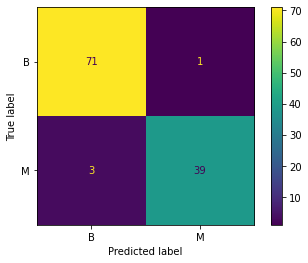


Matriz de confusão do modelo nos dados de teste:

              precision    recall  f1-score   support

           B       0.96      0.99      0.97        72
           M       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [17]:
# logit (regressão logistica)

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)


######################## PIPELINE

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('scaler', StandardScaler()),
                 ('logit', LogisticRegression(solver="saga", max_iter=500))])

######################## GRID SEARCH

from sklearn.model_selection import GridSearchCV

param_grid_en = {'logit__penalty': ["elasticnet"],
                 'logit__C': np.linspace(0.1, 10, 20),
                 'logit__l1_ratio' : [0.2, 0.5, 0.7]}

# PRA OTIMIZAR UMA METRICA QUE TEM DUAS OPÇOES
from sklearn.metrics import recall_score, make_scorer

metrica = make_scorer(recall_score, pos_label="M")

grid_en = GridSearchCV(pipe, param_grid_en, scoring=metrica, cv=5, verbose=1.5)

grid_en.fit(X_train, y_train)

y_pred = grid_en.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusão do modelo nos dados de teste:\n")
print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(grid_en, X_test, y_test)
plt.show()

print("\nMatriz de confusão do modelo nos dados de teste:\n")
print(classification_report(y_test, y_pred))

____
____
____

## 3) KNN para regressão

O KNN é nosso primeiro exemplo de algoritmo que pode ser utilizado para ambos os problemas de classificação e regressão!

A ideia é bem simples: o target atribuído a uma nova observação é igual à **média do target das $k$ observações mais próximas**

<img src="https://bookdown.org/f100441618/bookdown-regresion/www/KNN.jpg" width=500>

Naturalmente, também para regressão o parâmetro $k$ e a métrica de distância são hiperparâmetros importantes:

<img src="https://i.stack.imgur.com/gAILq.png" width=500>

A classe no sklearn é a [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). Dê uma olhada no User Guide e também no [RadiusNeighborsRegressor!](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor)

In [24]:
df_houses = pd.read_csv("../datasets/house_prices.csv")

In [29]:
nulos = df_houses.isnull().sum()

nulos_2 = nulos[nulos!=0] / df_houses.shape[0]

In [31]:
nulos_2[nulos_2 > 0.5].index

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [32]:
df_houses = df_houses.drop(columns=nulos_2[nulos_2 > 0.5].index)

In [34]:
nulos = df_houses.isnull().sum()

nulos_2 = nulos[nulos!=0] / df_houses.shape[0]

df_houses = df_houses.drop(columns=["LotFrontage", "FireplaceQu"])

In [37]:
nulos = df_houses.isnull().sum()

nulos_2 = nulos[nulos!=0]

In [39]:
df_houses.shape

(1460, 75)

In [41]:
df_houses = df_houses.dropna()

In [42]:
nulos = df_houses.isnull().sum()

nulos_2 = nulos[nulos!=0]

nulos_2

Series([], dtype: int64)

In [43]:
df_houses.shape

(1338, 75)

In [45]:
df_houses = df_houses.select_dtypes(include=np.number)

In [46]:
df_houses.shape

(1338, 37)

Agora sim, base pronta pra modelagem!!

In [47]:
df_houses.columns

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [55]:
# use o knn para produzir um modelo de regressão para o house-datasets. faça um grid search para encontrar o melhor valor de k.

X = df_houses.drop(columns=["Id", "SalePrice"])
y = df_houses["SalePrice"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)


######################## PIPELINE

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor())])

######################## GRID SEARCH

from sklearn.model_selection import GridSearchCV

param_grid_reg = {'knn__n_neighbors': np.arange(2, 20),
                  'knn__weights':['uniform', 'distance'], 
                  'knn__metric':["euclidean", 'manhattan', "chebyshev", "minkowski"],
                  'knn__p' : [1, 2, 3, 4]}

grid_reg = GridSearchCV(pipe, param_grid_reg, scoring="neg_root_mean_squared_error", cv=5, verbose=1.5)

grid_reg.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=uniform, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=2, knn__p=1, knn__weights=distance, total=   0.1s
[CV] knn__metric=eucli

[CV] knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=uniform, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=uniform, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=distance, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=distance, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=3, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neig

[CV]  knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=uniform, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.1s
[CV] knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=eucli

[CV]  knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=5, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean

[CV]  knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=7, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclide

[CV]  knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=8, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=eucli

[CV]  knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=9, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=eucli

[CV]  knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=10, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=

[CV]  knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=12, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metri

[CV]  knn__metric=euclidean, knn__n_neighbors=13, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=13, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=e

[CV]  knn__metric=euclidean, knn__n_neighbors=15, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=15, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=15, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=15, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=15, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=15, knn__p=3, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=15, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=15, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=15, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=15, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=15, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__me

[CV]  knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=16, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=17, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=17, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__

[CV]  knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=18, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn_

[CV]  knn__metric=euclidean, knn__n_neighbors=19, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=19, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=19, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=19, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=19, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=19, knn__p=2, knn__weights=distance 
[CV]  knn__metric=euclidean, knn__n_neighbors=19, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=19, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=19, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=euclidean, knn__n_neighbors=19, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=euclidean, knn__n_neighbors=19, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__me

[CV]  knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=2, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manha

[CV]  knn__metric=manhattan, knn__n_neighbors=3, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=3, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=3, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=3, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=3, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=4, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=4, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=4, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=4, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=4, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=4, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhatta

[CV]  knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=5, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=5, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manh

[CV]  knn__metric=manhattan, knn__n_neighbors=6, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=6, knn__p=2, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=6, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=6, knn__p=2, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=6, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=6, knn__p=2, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=6, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=6, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=6, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=6, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=6, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhat

[CV]  knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=7, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manha

[CV]  knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=distance, total=   0.1s
[CV] knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=8, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan

[CV]  knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=10, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=

[CV]  knn__metric=manhattan, knn__n_neighbors=11, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=11, knn__p=1, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=11, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=11, knn__p=1, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=11, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=11, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=11, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=11, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=11, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=11, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=11, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metr

[CV]  knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=12, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=12, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=12, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__

[CV]  knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=13, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn_

[CV]  knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=14, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metri

[CV]  knn__metric=manhattan, knn__n_neighbors=15, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=16, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=m

[CV]  knn__metric=manhattan, knn__n_neighbors=17, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=17, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=m

[CV]  knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=18, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metri

[CV]  knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=distance 
[CV]  knn__metric=manhattan, knn__n_neighbors=19, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__m

[CV]  knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebysh

[CV]  knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=4, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, 

[CV]  knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=5, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, 

[CV]  knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=6, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev

[CV]  knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=8, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, 

[CV]  knn__metric=chebyshev, knn__n_neighbors=9, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=9, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, k

[CV]  knn__metric=chebyshev, knn__n_neighbors=10, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=10, knn__p=2, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=10, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=10, knn__p=2, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=10, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=10, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=10, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=10, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=10, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=10, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=10, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metr

[CV]  knn__metric=chebyshev, knn__n_neighbors=11, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=11, knn__p=3, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=11, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=11, knn__p=3, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=11, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=11, knn__p=3, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=11, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=11, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=11, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=11, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=11, knn__p=4, knn__weights=uniform, total=   0.0s
[CV] knn__me

[CV]  knn__metric=chebyshev, knn__n_neighbors=12, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=12, knn__p=4, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=12, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=12, knn__p=4, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=12, knn__p=4, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=13, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=13, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=13, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metr

[CV]  knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=14, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn_

[CV]  knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=15, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__m

[CV]  knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=distance, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=16, knn__p=3, knn__weights=distance, total=   0.1s
[CV] knn__met

[CV]  knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=17, knn__p=4, knn__weights=distance, total=   0.1s
[CV] knn__metric=

[CV]  knn__metric=chebyshev, knn__n_neighbors=18, knn__p=4, knn__weights=distance, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=18, knn__p=4, knn__weights=distance 
[CV]  knn__metric=chebyshev, knn__n_neighbors=18, knn__p=4, knn__weights=distance, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=19, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=19, knn__p=1, knn__weights=uniform, total=   0.1s
[CV] knn__metric=chebyshev, knn__n_neighbors=19, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=19, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=19, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=19, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=chebyshev, knn__n_neighbors=19, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=chebyshev, knn__n_neighbors=19, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric

[CV]  knn__metric=minkowski, knn__n_neighbors=2, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=2, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=2, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=2, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=2, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=2, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=2, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=2, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=2, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=2, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=2, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski,

[CV]  knn__metric=minkowski, knn__n_neighbors=3, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=3, knn__p=2, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=3, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=3, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=3, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=3, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=3, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=3, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=3, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=3, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=3, knn__p=3, knn__weights=uniform, total=   0.3s
[CV] knn__metric=minkowski,

[CV]  knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=4, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=4, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=mink

[CV]  knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=5, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkows

[CV]  knn__metric=minkowski, knn__n_neighbors=6, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, k

[CV]  knn__metric=minkowski, knn__n_neighbors=8, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=8, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=8, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=8, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=8, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=8, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=8, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=8, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=8, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=8, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=8, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski,

[CV]  knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=9, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, 

[CV]  knn__metric=minkowski, knn__n_neighbors=10, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=10, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=10, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=10, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=10, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=10, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=10, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=10, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=10, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=10, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=10, knn__p=4, knn__weights=uniform, total=   0.3s
[CV] knn__metr

[CV]  knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance, total=   0.3s
[CV] knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance, total=   0.4s
[CV] knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=11, knn__p=4, knn__weights=distance, total=   0.3s
[CV] knn_

[CV]  knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance, total=   0.1s
[CV] knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance, total=   0.1s
[CV] knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=13, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn_

[CV]  knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=uniform, total=   0.1s
[CV] knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=uniform, total=   0.1s
[CV] knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=uniform, total=   0.1s
[CV] knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=14, knn__p=2, knn__weights=distance, total=   0.1s
[CV] knn__met

[CV]  knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform, total=   0.3s
[CV] knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform, total=   0.3s
[CV] knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=15, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=

[CV]  knn__metric=minkowski, knn__n_neighbors=16, knn__p=3, knn__weights=distance, total=   0.3s
[CV] knn__metric=minkowski, knn__n_neighbors=16, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=16, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=16, knn__p=3, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=16, knn__p=3, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=16, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=16, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=16, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=16, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=16, knn__p=4, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=16, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metr

[CV]  knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=uniform, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=17, knn__p=4, knn__weights=distance, total=   0.2s
[CV] knn_

[CV]  knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance 
[CV]  knn__metric=minkowski, knn__n_neighbors=19, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__metric=minkowski, knn__n_neighbors=19, knn__p=2, knn__weights=uniform 
[CV]  knn__metric=minkowski, knn__n_neighbors=19, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__

[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:  3.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'chebyshev',
                                         'minkowski'],
                         'knn__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                         'knn__p': [1, 2, 3, 4],
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error', verbose=1.5)


####################################################



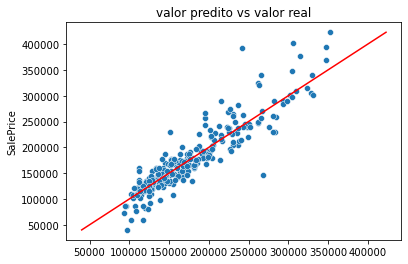

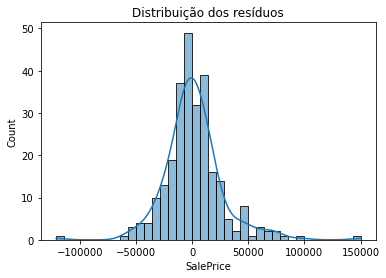


####################################################


Métricas de avaliação:
R^2: 0.8372870930301526
MAE: 17847.515559395193
MSE: 696265777.6544223
RMSE: 26386.848573757765


In [56]:
y_pred = grid_reg.predict(X_test)

print("\n####################################################\n")

# 5)
plt.title("valor predito vs valor real")
sns.scatterplot(x=y_pred, y=y_test)

range_y_test = np.linspace(y_test.min(), y_test.max(), 1000)
plt.plot(range_y_test, range_y_test, "red")

plt.show()

plt.title("Distribuição dos resíduos")
sns.histplot(y_test-y_pred, kde=True)
plt.show()

print("\n####################################################\n")

print("\nMétricas de avaliação:")

# 6)
from sklearn import metrics

print('R^2:', metrics.r2_score(y_test, y_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))